In [1]:
import pandas as pd
import functools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import numpy as np

In [2]:
plt.style.use('ggplot')

# Loading the Data

In [3]:
cols = ['book_authors', 'book_rating','book_rating_count', 'book_review_count', 'book_title', 'genres']
books = pd.read_csv('book_data.csv', usecols = cols)

In [4]:
books.head()

,book_authors,book_rating,book_rating_count,book_review_count,book_title,genres
0,Suzanne Collins,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...
1,J.K. Rowling|Mary GrandPré,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction
2,Harper Lee,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance
4,Stephenie Meyer,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...


In [5]:
books.describe()

,book_rating,book_rating_count,book_review_count
count,54301.000000,5.430100e+04,54301.00000
mean,4.020027,4.350449e+04,2011.60218
std,0.362100,2.126572e+05,7627.07287
min,0.000000,0.000000e+00,0.00000
25%,3.830000,4.070000e+02,35.00000
50%,4.030000,2.811000e+03,188.00000
75%,4.220000,1.274500e+04,822.00000
max,5.000000,5.588580e+06,160776.00000


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_authors       54301 non-null  object 
 1   book_rating        54301 non-null  float64
 2   book_rating_count  54301 non-null  int64  
 3   book_review_count  54301 non-null  int64  
 4   book_title         54301 non-null  object 
 5   genres             51059 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ MB


# Cleaning the data

I'm interested in Genres, so I need to clean the genres into a usuable format. First, around 3000 of them are null. This is only around 5% of our data, so I don't feel to bad dropping them. They're all saved as a string separated by pipe characters, so I first want to make that into a bonafide list of genres, then map that to a one-hot encoded column for each book. (To do this I map it to a dictionary first, then use that to create the one hot encoding). This would be easier to do directly, but one issue I ran into was that there were around 900 different genres. Obviously I don't want to add 900 different columns, so I chose to examine the top 30 genres instead.

In [7]:
how_many_genres = 30

In [8]:
books = books.dropna()

In [9]:
def pipesToDict(words):
    wordList = str(words).split('|')
    d = {}
    for word in wordList:
        if word in d:
            d[word] += 1
        else:
            d[word] = 1
    return d

In [10]:
def genreCounts(d1, d2):
    result = d1.copy()
    for word in d2.keys():
        if word in result:
            result[word] += 1
        else:
            result[word] = 1
    return result

In [11]:
genres = books['genres']

In [12]:
books['genreDicts'] = genres.apply(pipesToDict)

In [13]:
genresDicts= list(books['genreDicts'].values)

Now I have each books list of genres as a dictionary, so I want to see which genres are the most popular, and only use those to make new columns

In [14]:
genrecount = functools.reduce(genreCounts, genresDicts)

In [15]:
{k: v for k, v in sorted(genrecount.items(), key=lambda item: item[1])[-how_many_genres:]}

{'Sequential Art': 1726,
 'Autobiography': 1763,
 'Religion': 1817,
 'Short Stories': 1847,
 'Philosophy': 1940,
 'Crime': 2080,
 'Contemporary Romance': 2115,
 'Humor': 2151,
 'Adventure': 2267,
 'Horror': 2316,
 'Biography': 2370,
 'Novels': 2553,
 'History': 2683,
 'European Literature': 2954,
 'Thriller': 3045,
 'Literature': 3792,
 'Childrens': 3966,
 'Cultural': 4972,
 'Science Fiction': 5137,
 'Paranormal': 5176,
 'Mystery': 5681,
 'Contemporary': 6064,
 'Classics': 6316,
 'Historical Fiction': 6408,
 'Historical': 7120,
 'Nonfiction': 7727,
 'Young Adult': 10533,
 'Romance': 12899,
 'Fantasy': 14295,
 'Fiction': 26007}

In [16]:
topGenres = [ k for k, v in sorted(genrecount.items(), key=lambda item: item[1])[-how_many_genres:]]

This just makes the new genres as columns

In [17]:
for genre in topGenres:
    books[genre] = books['genres'].apply(lambda x: 1 if genre in x else 0)

# Visualizations

Now I want to create visualizations of my data. To do this I extract the number of books and the averages into a list where each elements value corresponds to that value in the topGenres list. Because I'm gonna be comparing the in-genre vs out-of-genre values later, I also extract the same values for the out of genre values.

In [18]:
colors = ['b']*how_many_genres
comp_colors = ['r']*how_many_genres

In [19]:
genreBookCounts = []
for genre in topGenres:
    genreBookCounts.append(books.groupby(genre).count()['book_title'].values[1])

In [20]:
genreAverages = []
for genre in topGenres:
    genreAverages.append(books.groupby(genre).mean()['book_rating'].values[1])

In [21]:
nonGenreAverages = []
for genre in topGenres:
    nonGenreAverages.append(books.groupby(genre).mean()['book_rating'].values[0])

In [22]:
genreReviewCounts = []
for genre in topGenres:
    genreReviewCounts.append(books.groupby(genre).mean()['book_rating_count'].values[1])

In [23]:
nonGenreReviewCounts = []
for genre in topGenres:
    nonGenreReviewCounts.append(books.groupby(genre).mean()['book_rating_count'].values[0])

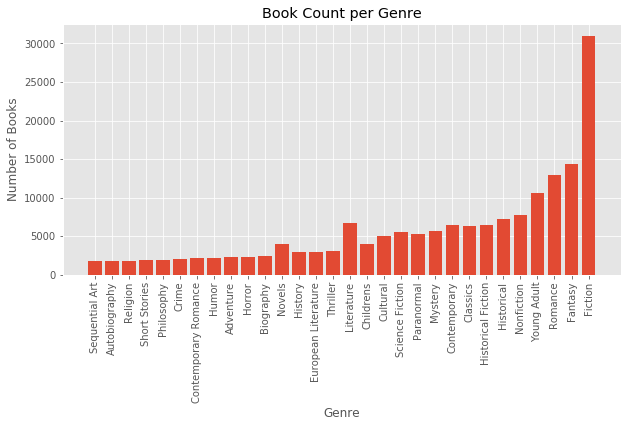

In [24]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreBookCounts)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Number of Books')
plt.xlabel('Genre')
plt.title('Book Count per Genre')
plt.savefig('Images/BookCount.png')
pass

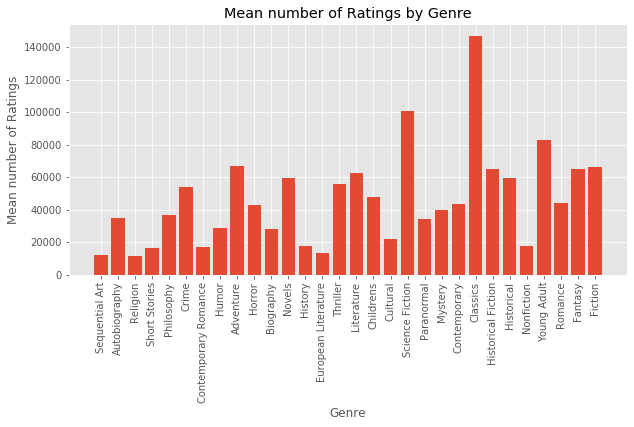

In [25]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreReviewCounts)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Mean number of Ratings')
plt.xlabel('Genre')
plt.title('Mean number of Ratings by Genre')
plt.savefig('RatingsPerBook.png')
plt.savefig('Images/meanNumberRatings.png')
pass

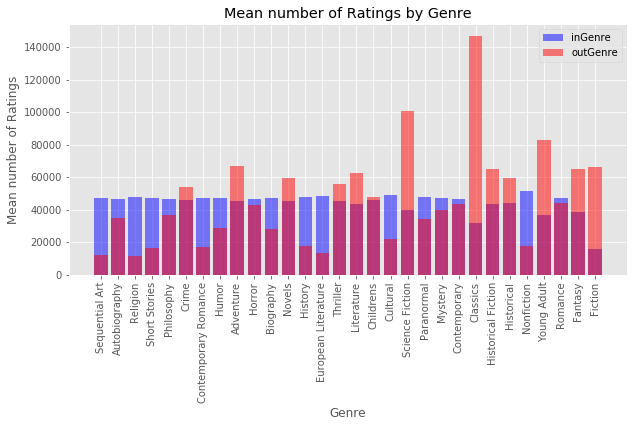

In [26]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= nonGenreReviewCounts, alpha = .5, color = colors, label = 'inGenre')
plt.bar(x = topGenres, height= genreReviewCounts, alpha = .5, color = comp_colors, label = 'outGenre')
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Mean number of Ratings')
plt.xlabel('Genre')
plt.title('Mean number of Ratings by Genre')
plt.legend()
plt.savefig('Images/meanNumberRatingsComped.png')
pass

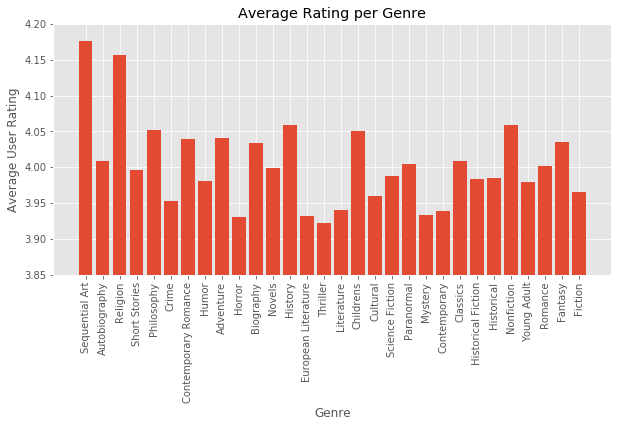

In [27]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreAverages)
plt.ylim(3.85, 4.2)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Average User Rating')
plt.xlabel('Genre')
plt.title('Average Rating per Genre')
plt.savefig('Images/Ratings.png')
pass

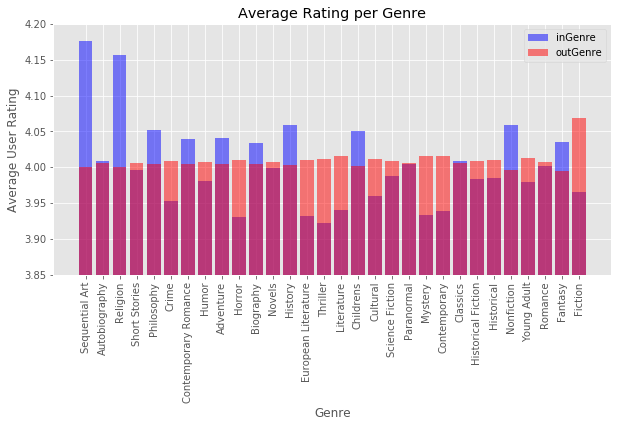

In [28]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreAverages, color = colors, alpha = .5, label = 'inGenre')
plt.bar(x = topGenres, height= nonGenreAverages, color = comp_colors, alpha = .5, label = 'outGenre')
plt.ylim(3.85, 4.2)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Average User Rating')
plt.xlabel('Genre')
plt.title('Average Rating per Genre')
plt.legend()
plt.savefig('Images/ratingsComped.png')
pass

From these graphs, the values between the ratings don't seem terrible varied, the minimum rating is around 3.9 and the max is around 4.17, the number of ratings look a lot more varied though. It would be interesting to see if this is a statistically significant difference or not, so I decided to run some hypothesis tests.

# Hypothesis Tests

From our graphs, we ran two batches of hypothesis tests, each one consisting of 30 tests, one for each genres. We use a two-sided Welch T-Test because our data follows approximately a normal distribution (note: this is something I investigated in the messy analysis notebook, but have decided not to include here for brevitys sake).

In [29]:
rating_colors = []
rating_results = []
for genre in topGenres:
    inGenre = books[books[genre] == 1]
    outGenre = books[books[genre] == 0]
    test_result = stats.ttest_ind(inGenre['book_rating'], outGenre['book_rating'], equal_var=False)
    rating_results.append(test_result[1])
    print(genre, test_result[1])
    if test_result[1] < .025:
        rating_colors.append('r')
    else:
        rating_colors.append('g')

Sequential Art 1.1931176781062184e-130
Autobiography 0.6643499511484978
Religion 3.0180218256097446e-97
Short Stories 0.15456978475208738
Philosophy 8.376618208703289e-16
Crime 1.483598658946656e-23
Contemporary Romance 4.130630248379327e-11
Humor 6.275382427174675e-05
Adventure 3.6940253742713063e-10
Horror 6.964702166070827e-32
Biography 2.7894776261997065e-07
Novels 0.12230171656369644
History 6.387065101376643e-29
European Literature 1.008013901527007e-40
Thriller 2.6022292900786667e-70
Literature 2.742962173799661e-82
Childrens 1.8741667694416372e-28
Cultural 8.142313071501023e-33
Science Fiction 2.1464829115006615e-07
Paranormal 0.7108223475703508
Mystery 5.402493002816961e-106
Contemporary 2.2538431458927086e-89
Classics 0.3559833485107412
Historical Fiction 1.2489281091556376e-12
Historical 6.78848177627637e-13
Nonfiction 1.1968712034346987e-72
Young Adult 8.485019709312739e-27
Romance 0.0625134056482089
Fantasy 2.4709966723357575e-44
Fiction 0.0


In [30]:
num_rating_colors = []
num_rating_results = []
for genre in topGenres:
    inGenre = books[books[genre] == 1]
    outGenre = books[books[genre] == 0]
    test_result = stats.ttest_ind(inGenre['book_rating_count'], outGenre['book_rating_count'], equal_var=False)
    num_rating_results = test_result[1]
    print(genre, test_result[1])
    if test_result[1] < .025:
        num_rating_colors.append('r')
    else:
        num_rating_colors.append('g')

Sequential Art 6.822594451169078e-168
Autobiography 0.002971279522157497
Religion 3.682215139799608e-132
Short Stories 4.371010809423833e-87
Philosophy 0.0019525218856833234
Crime 0.08749050366698732
Contemporary Romance 1.2927096391012463e-111
Humor 1.6241368921026749e-18
Adventure 0.0012256740353603624
Horror 0.20766531218529435
Biography 1.1254479135709061e-10
Novels 0.0036398772514752587
History 3.97547423738832e-39
European Literature 6.012395138907308e-107
Thriller 0.013807842801222693
Literature 6.231687243154113e-08
Childrens 0.6577450823771334
Cultural 1.4579286414185043e-69
Science Fiction 1.361303367299278e-30
Paranormal 7.728430405721866e-08
Mystery 0.0039751362785966395
Contemporary 0.1955347274587004
Classics 1.0890527529462178e-98
Historical Fiction 1.8370094119127045e-09
Historical 3.840558678752825e-06
Nonfiction 1.2909248427827869e-111
Young Adult 1.977877330202468e-41
Romance 0.1885780545357754
Fantasy 4.269247537533981e-26
Fiction 2.424944846941832e-205


Now to visualize this, I plotted the values back in a bar chart, but this time changing the color to red if it rejected the null hypothesis, green if it didn't.

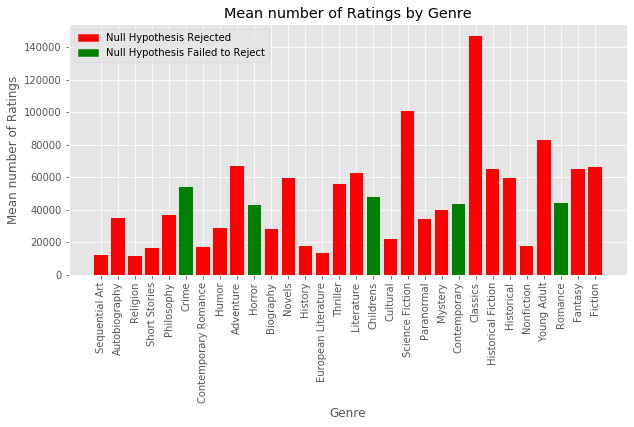

In [31]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreReviewCounts, color = num_rating_colors)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Mean number of Ratings')
plt.xlabel('Genre')
plt.title('Mean number of Ratings by Genre')
red_patch = mpatches.Patch(color='red', label='Null Hypothesis Rejected')
green_patch = mpatches.Patch(color='green', label='Null Hypothesis Failed to Reject')
plt.legend(handles=[red_patch, green_patch])
plt.savefig('Images/testedMeanNumberRatings.png')
pass

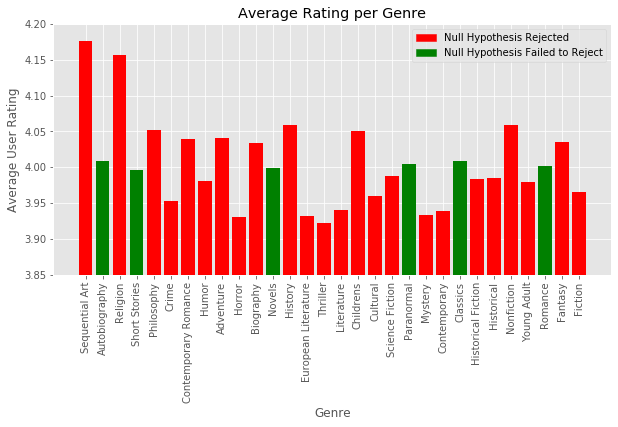

In [32]:
plt.figure(figsize=(10,6))
plt.bar(x = topGenres, height= genreAverages, color = rating_colors)
plt.ylim(3.85, 4.2)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3)
plt.ylabel('Average User Rating')
plt.xlabel('Genre')
plt.title('Average Rating per Genre')
red_patch = mpatches.Patch(color='red', label='Null Hypothesis Rejected')
green_patch = mpatches.Patch(color='green', label='Null Hypothesis Failed to Reject')
plt.legend(handles=[red_patch, green_patch])
plt.savefig('Images/TestedRatings.png')
pass

Some comments about the results:

We did a lot more rejecting than failing to reject in these tests despite the fact that a lot of our data is within close margins to its complement. The primary reason for this seems to be how big our sample size is vs how small our standard deviation is. With 54 thousand books and a small standard deviation, we really get a small standard error when we do the p-value calculation which allows us to detect very minute differences in our datasets. So while we're saying that each rating per genre is different from its out of genre counterpart, we're only sayings its different by a small amount.

# Additional Work

### YA vs Non-YA Fantasy

A lot of my reading this year has been fantasy books, so I was interested in seeing if there was a statistically significant difference in the average rating between YA fantasy books and non-YA ones. Again I ran a two-sided welch t-test to see if the difference was significant (the populations were approximately normally distributed, you can see this in the messy analysis notebook).

In [33]:
FantasyBooks = books[books['Fantasy'] == 1]
FantasyBooks.head()

,book_authors,book_rating,book_rating_count,book_review_count,book_title,genres,genreDicts,Sequential Art,Autobiography,Religion,...,Mystery,Contemporary,Classics,Historical Fiction,Historical,Nonfiction,Young Adult,Romance,Fantasy,Fiction
0,Suzanne Collins,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,"{'Young Adult': 1, 'Fiction': 1, 'Science Fict...",0,0,0,...,0,0,0,0,0,0,1,0,1,1
1,J.K. Rowling|Mary GrandPré,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,"{'Fantasy': 1, 'Young Adult': 1, 'Fiction': 1}",0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,Stephenie Meyer,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,"{'Young Adult': 1, 'Fantasy': 2, 'Romance': 1,...",0,0,0,...,0,0,0,0,0,0,1,1,1,1
6,C.S. Lewis|Pauline Baynes,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,"{'Fantasy': 1, 'Classics': 1, 'Fiction': 1, 'Y...",0,0,0,...,0,0,1,0,0,0,1,0,1,1
7,George Orwell,3.90,2235084,42156,Animal Farm,Classics|Fiction|Science Fiction|Dystopia|Fant...,"{'Classics': 1, 'Fiction': 1, 'Science Fiction...",0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [34]:
FantasyYA = FantasyBooks[FantasyBooks['Young Adult'] == 1]
FantasyNYA = FantasyBooks[FantasyBooks['Young Adult'] == 0]

In [35]:
print('YA Mean: ' + str(FantasyYA['book_rating'].mean()))
print('Non-YA Mean: ' + str(FantasyNYA['book_rating'].mean()))

YA Mean: 4.019174647396831
Non-YA Mean: 4.045309284310325


In [36]:
stats.ttest_ind(FantasyYA['book_rating'], FantasyNYA['book_rating'], equal_var=False)[1]

7.285574140023429e-08

So with farily high confidence we can say that the YA books are rated a little lower, even though the absolute difference in their ratings is only ~.025

### Power Analysis

I was also interested in computing the power of our results, I had code leftover that computed the power of a one tailed test so I applied this to a two tailed setting by adjusting which tail was being computed based on which mean was higher. 

In [37]:
def compute_power(n, sigma, alpha, mu0, mua):
    standard_error = sigma / n**0.5
    h0 = stats.norm(mu0, standard_error)
    ha = stats.norm(mua, standard_error)
    critical_value = h0.ppf(1 - alpha)
    power = 1 - ha.cdf(critical_value)
    return power

In [38]:
powers = []
for i in range(len(topGenres)):
    genre = topGenres[i]
    inGenre = books[books[genre] == 1]
    outGenre = books[books[genre] == 0]
    inGenreMean = inGenre['book_rating'].mean()
    outGenreMean = outGenre['book_rating'].mean()
    std = books['book_rating'].std()
    print(genre, inGenreMean, outGenreMean)
    if inGenreMean > outGenreMean:
        powers.append(compute_power(len(books), std, .975, outGenreMean, inGenreMean))
    else:
        powers.append(compute_power(len(books), std, .025,inGenreMean, outGenreMean))

Sequential Art 4.176315179606025 4.000117365657876
Autobiography 4.008706749858196 4.005979389808504
Religion 4.1564446890478814 4.000524958368872
Short Stories 3.9967569030860854 4.006423230106479
Philosophy 4.052489690721649 4.004240314338647
Crime 3.952533653846154 4.008347250862615
Contemporary Romance 4.039895981087471 4.004612005557371
Humor 3.9801813110181317 4.007212317003353
Adventure 4.040740414279418 4.004461365033817
Horror 3.930988773747841 4.00964117924625
Biography 4.033628428927681 4.00471091196843
Novels 3.998601294176207 4.00671180459599
History 4.058634835238736 4.0028227097847555
European Literature 3.9326100203114422 4.010584762498701
Thriller 3.9220520231213873 4.011530712274481
Literature 3.9399625355911887 4.016012706709323
Childrens 4.050015128593041 4.002372964134797
Cultural 3.959837185929649 4.011065011717733
Science Fiction 3.9873514674302077 4.008374348485848
Paranormal 4.0046680696384165 4.006233854075755
Mystery 3.932982364239567 4.0153075090443835
Conte

In [39]:
print(powers)

[1.0, 0.9999715070414912, 1.0, 0.9999999581105181, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999985477296815, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2193333619006539, 1.0, 1.0, 0.999995535425619, 1.0, 1.0, 1.0, 1.0, 0.9858517738277399, 1.0, 1.0]


In general, all of our tests were extremely powerful. The one exception were books in the paranormal genre which for some reason had a much lower power on their test than every other genre. This requires further analysis to see why this is

In [40]:
for i in range(len(powers)):
    if powers[i] < .5:
        print(topGenres[i], powers[i])

Paranormal 0.2193333619006539
